### Part A

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Add, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
from train_valid_test_loader import load_train_valid_test_datasets

### Importing Data

In [3]:
movies_df = pd.read_csv('/Users/brandonmukadziwashe/CS135/cs135-24f-assignments/CS-135-Project-B/data_movie_lens_100k/movie_info.csv')
ratings_df = pd.read_csv('/Users/brandonmukadziwashe/CS135/cs135-24f-assignments/CS-135-Project-B/data_movie_lens_100k/ratings_all_development_set.csv')
ratings_df = ratings_df.rename(columns={'user_id': 'userId', 'item_id': 'movieId'})
movies_df = movies_df.rename(columns={'item_id': 'movieId'})
leaderboard_data = pd.read_csv('/Users/brandonmukadziwashe/CS135/cs135-24f-assignments/CS-135-Project-B/data_movie_lens_100k/ratings_masked_leaderboard_set.csv') 

### Data Preprocessing

In [4]:
# Ensure required columns exist
assert 'userId' in ratings_df.columns and 'movieId' in ratings_df.columns and 'rating' in ratings_df.columns

# Encode user and movie IDs
user_encoder = LabelEncoder()
ratings_df['user_id_encoded'] = user_encoder.fit_transform(ratings_df['userId'])

movie_encoder = LabelEncoder()
ratings_df['movie_id_encoded'] = movie_encoder.fit_transform(ratings_df['movieId'])

# ratings_df, actual_ratings_testing_df = train_test_split(ratings_df, test_size=0.15, random_state=42)

# Copy the dataset and split into train and test sets
df = ratings_df.copy()
train, test = train_test_split(df, test_size=0.2, random_state=42)
# train, valid_tuple, test_tuple, n_users, n_items = load_train_valid_test_datasets()

# Convert columns to NumPy arrays
train_user_ids = np.array(train['user_id_encoded'].values)
train_movie_ids = np.array(train['movie_id_encoded'].values)
train_ratings = np.array(train['rating'].values)

test_user_ids = np.array(test['user_id_encoded'].values)
test_movie_ids = np.array(test['movie_id_encoded'].values)
test_ratings = np.array(test['rating'].values)

# actual_test_user_ids = np.array(actual_ratings_testing_df['user_id_encoded'].values)
# actual_test_movie_ids = np.array(actual_ratings_testing_df['movie_id_encoded'].values)
# actual_test_ratings = np.array(actual_ratings_testing_df['rating'].values)


# Define the number of unique users, movies, and embedding dimensions
num_users = df['user_id_encoded'].nunique()
num_movies = df['movie_id_encoded'].nunique()
embedding_dim = 50

### Getting embeddings

In [5]:
# User input and embedding
user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=num_users + 1, output_dim=embedding_dim, name='user_embedding')(user_input)
user_embedding = Flatten()(user_embedding)

# Movie input and embedding
movie_input = Input(shape=(1,), name='movie_input')
movie_embedding = Embedding(input_dim=num_movies + 1, output_dim=embedding_dim, name='movie_embedding')(movie_input)
movie_embedding = Flatten()(movie_embedding)

### Defining the model and training

In [6]:
# Define the model

# Dot product of embeddings and output layer
dot_product = Dot(axes=1)([user_embedding, movie_embedding])
output = Dense(1, activation='linear')(dot_product)

# Compile the model
model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer='adam', loss='mae')

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    [train_user_ids, train_movie_ids], train_ratings,
    epochs=20,
    batch_size=64,
    validation_data=([test_user_ids, test_movie_ids], test_ratings),
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss = model.evaluate([test_user_ids, test_movie_ids], test_ratings)
print(f"Test loss (MAE): {test_loss}")

Epoch 1/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.9553 - val_loss: 0.8409
Epoch 2/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7847 - val_loss: 0.7666
Epoch 3/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7157 - val_loss: 0.7538
Epoch 4/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6734 - val_loss: 0.7426
Epoch 5/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6302 - val_loss: 0.7440
Epoch 6/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5863 - val_loss: 0.7461
Epoch 7/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5412 - val_loss: 0.7550
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 0.7459
Test loss (MAE): 0.742592453956604


### Making the predictions

In [ ]:
# Predict ratings for the test set
test_predictions = model.predict([test_user_ids, test_movie_ids])

# Create a DataFrame with predictions
test_results = pd.DataFrame({
    'original_user_id': test['userId'],
    'original_movie_id': test['movieId'],
    'actual_rating': test_ratings,
    'predicted_rating': test_predictions.flatten()
})
test_results['rating_difference'] = abs(test_results['actual_rating'] - test_results['predicted_rating'])

# Filter results for a specific user and sort by rating difference
filter_user_id = 772  # Replace with your desired user ID
filtered_results = test_results[test_results['original_user_id'] == filter_user_id]
filtered_results_sorted = filtered_results.sort_values(by='rating_difference')

print(f"Predictions for user {filter_user_id}, ordered by closest rating difference:")
print(filtered_results_sorted)


# Load leaderboard data
leaderboard_data = pd.read_csv('/Users/brandonmukadziwashe/CS135/cs135-24f-assignments/CS-135-Project-B/data_movie_lens_100k/ratings_masked_leaderboard_set.csv')  # Replace with your leaderboard file path
assert 'user_id' in leaderboard_data.columns and 'item_id' in leaderboard_data.columns

# Handle unseen user and movie IDs using mapping
user_mapping = dict(zip(user_encoder.classes_, user_encoder.transform(user_encoder.classes_)))
movie_mapping = dict(zip(movie_encoder.classes_, movie_encoder.transform(movie_encoder.classes_)))

# Map user and movie IDs, assigning unseen IDs to placeholder index
leaderboard_data['user_id_encoded'] = leaderboard_data['user_id'].map(
    lambda x: user_mapping.get(x, num_users)
).astype(int)

leaderboard_data['item_id_encoded'] = leaderboard_data['item_id'].map(
    lambda x: movie_mapping.get(x, num_movies)
).astype(int)

# Predict leaderboard ratings
user_ids = leaderboard_data['user_id_encoded'].values
item_ids = leaderboard_data['item_id_encoded'].values
predictions = model.predict([user_ids, item_ids]).flatten()

# Save leaderboard predictions to a file
with open("predicted_ratings_leaderboard3.txt", "w") as f:
    for pred in predictions:
        f.write(f"{pred}\n")

563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
Predictions for user 772, ordered by closest rating difference:
       original_user_id  original_movie_id  actual_rating  predicted_rating  \
76753               772                230              2          1.845560   
89978               772                728              3          3.239117   
74901               772                187              3          3.273921   
67026               772                893              2          2.331681   
13524               772                565              2          2.444174   
8138                772                431              3          3.500109   
74708               772                126              5          4.498601   
70790               772               1034              3          2.461379   
10398               772                946              2          1.399315   
89249               772                391              2          2.735776   
44904               772 

In [66]:
test_results = test_results.sort_values(by='rating_difference')
print(test_results)
user_info_df = pd.read_csv('/Users/brandonmukadziwashe/CS135/cs135-24f-assignments/CS-135-Project-B/data_movie_lens_100k/user_info.csv')

       original_user_id  original_movie_id  actual_rating  predicted_rating  \
73450               566                202              4          3.999826   
57029               652                166              2          1.999760   
24388               768                822              2          1.999724   
12687                42                 27              4          3.999707   
36853               793                126              5          4.999625   
...                 ...                ...            ...               ...   
29170               309               1384              1          4.901651   
15444               188                514              1          4.911760   
82137               404                450              5          1.066333   
5266                166               1304              5          0.892661   
29595                89               1199              5          0.848530   

       rating_difference  
73450           0.000174

In [89]:
# Assuming the DataFrame is named `df`
user_counts = ratings_df['userId'].value_counts().reset_index()
user_counts.columns = ['userId', 'count']  # Rename columns for clarity
# Display the resulting DataFrame
#print(user_counts)

top_10_users = user_counts.head(10)
#print(top_10_users)
worst_10_users = user_counts.tail(10)

filtered_users = user_counts[(user_counts['count'] >= 100) & (user_counts['count'] <= 190)]

# Get the first 10 users within this range (if available)
middle_10_users = filtered_users.head(10)
print(middle_10_users)

# print("Old 10 Users")
# print("=================================") 
# for user_id in top_10_users['userId']:
#     print("---------------------------------")
#     rating_diff = test_results[test_results['original_user_id'] == user_id]
#     rat = rating_diff['rating_difference']
#     print(user_id, ":", rat.mean())

print("Middle 10 Users")
print("=================================")
for user_id in middle_10_users['userId']:
    print("---------------------------------")
    rating_diff = test_results[test_results['original_user_id'] == user_id]
    rat = rating_diff['rating_difference']
    print(user_id, ":", rat.mean())

# print("Newest 10 Users")
# print("=================================")  
# for user_id in worst_10_users['userId']:
#     print("---------------------------------")
#     rating_diff = test_results[test_results['original_user_id'] == user_id]
#     rat = rating_diff['rating_difference']
#     print(user_id, ":", rat.mean())

     userId  count
137     850    189
138      59    189
139     842    188
140      86    187
141     806    186
142     451    185
143     143    185
144     341    184
145     478    183
146     294    182
Middle 10 Users
---------------------------------
850 : 0.6409886556286966
---------------------------------
59 : 0.5922094555788262
---------------------------------
842 : 0.6433472633361816
---------------------------------
86 : 0.6285422696007623
---------------------------------
806 : 0.8096293108803886
---------------------------------
451 : 1.0745351687073708
---------------------------------
143 : 0.5770665070949457
---------------------------------
341 : 0.9387479761372441
---------------------------------
478 : 0.7195881174670326
---------------------------------
294 : 0.5084927082061768


In [63]:
best_predictions = test_results.head(20)
best_ids = best_predictions['original_user_id'].values

for id in best_ids:
    count = ratings_df["userId"].value_counts().get(id, 0)
    age = user_info_df[user_info_df['user_id'] == id]['age'].values[0]
    is_male = user_info_df[user_info_df['user_id'] == id]['is_male'].values[0]
    print(id, count, age, is_male)


print("--------------------------------------------")
worst_predictions = test_results.tail(20)
worst_ids = worst_predictions['original_user_id'].values

for id in worst_ids:
    count = ratings_df["userId"].value_counts().get(id, 0)
    age = user_info_df[user_info_df['user_id'] == id]['age'].values[0]
    is_male = user_info_df[user_info_df['user_id'] == id]['is_male'].values[0]
    print(id, count, age, is_male)

566 140 24 1
652 255 31 1
768 24 39 1
42 193 29 0
793 33 32 1
396 91 17 1
404 643 22 0
803 299 39 1
832 244 34 1
503 220 40 0
93 366 26 1
628 108 46 0
93 366 26 1
873 31 36 1
86 187 47 1
415 441 20 0
889 107 32 1
643 41 51 1
789 204 27 1
379 148 32 1
--------------------------------------------
404 643 22 0
238 144 39 1
433 39 16 0
147 55 33 1
404 643 22 0
404 643 22 0
824 135 44 1
365 29 20 0
238 144 39 1
849 47 34 1
404 643 22 0
404 643 22 0
144 277 31 1
125 40 28 0
126 22 33 1
309 20 37 1
188 170 32 1
404 643 22 0
166 59 37 1
89 273 60 1


In [51]:
print("--------------------------------------------")
worst_predictions = test_results.tail(10)
worst_ids = worst_predictions['original_user_id'].values

for id in worst_ids:
    count = ratings_df["userId"].value_counts().get(id, 0)
    print(id, count)

--------------------------------------------
404 643
404 643
144 277
125 40
126 22
309 20
188 170
404 643
166 59
89 273


In [48]:
bmoid = best_predictions['original_movie_id'].values
for id in bmoid:
    count = ratings_df["movieId"].value_counts().get(id, 0)
    print(id, count)

202 156
166 63
822 49
27 255
126 374
703 125
784 12
744 110
858 15
124 222


### Finding best hyperparameters

In [ ]:
import itertools

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense
from sklearn.metrics import mean_absolute_error

def build_and_train_model(num_users, num_movies, embedding_dim, learning_rate, batch_size, epochs, patience, activation):
    # Define the model
    user_input = Input(shape=(1,), name='user_input')
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
    user_embedding = Flatten()(user_embedding)

    movie_input = Input(shape=(1,), name='movie_input')
    movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_dim, name='movie_embedding')(movie_input)
    movie_embedding = Flatten()(movie_embedding)

    dot_product = Dot(axes=1)([user_embedding, movie_embedding])
    output = Dense(1, activation=activation)(dot_product)

    model = Model(inputs=[user_input, movie_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae')

    # Add early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Train the model
    history = model.fit(
        [train_user_ids, train_movie_ids], train_ratings,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([test_user_ids, test_movie_ids], test_ratings),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate the model
    val_loss = model.evaluate([test_user_ids, test_movie_ids], test_ratings, verbose=0)
    return model, val_loss

# Define the hyperparameter grid
embedding_dims = [16, 32, 64, 128]
learning_rates = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]
activation = ['relu', 'linear']
epochs = [10, 50]
patience = 3

best_model = None
best_params = None
lowest_mae = float('inf')

results = {}
counter = 1

# Perform grid search
for emb_dim, lr, batch_size, act, epoch in itertools.product(embedding_dims, learning_rates, batch_sizes, activation, epochs):
    model, val_mae = build_and_train_model(num_users, num_movies, emb_dim, lr, batch_size, epoch, patience, act)

    print(counter)

    if val_mae < lowest_mae:
        lowest_mae = val_mae
        best_model = model
        best_params = (emb_dim, lr, batch_size)
        
    results[(emb_dim, lr, batch_size, act, epoch)] = val_mae

    counter += 1
    

### Obtaining the best, median and worst hyperparameters in terms of validation MAE

In [ ]:
sorted_items = sorted(results.items(), key=lambda x: x[1])

best_parameters = sorted_items[0][0]
n = len(sorted_items) // 2
mid_parameters = sorted_items[n][0]
worst_parameters = sorted_items[-1][0]

print(best_parameters, sorted_items[0][1])
print(mid_parameters, sorted_items[n][1])
print(worst_parameters, sorted_items[-1][1])

(128, 0.001, 256, 'linear', 50) 0.7286162376403809
(32, 0.01, 256, 'relu', 10) 0.7767121195793152
(128, 0.05, 32, 'linear', 10) 0.9238486289978027


### Plotting three hyperparameters

In [ ]:
emb_dim, lr, batch_size, act, epoch = best_parameters
best_model, best_val_mae = build_and_train_model(num_users, num_movies, emb_dim, lr, batch_size, epoch, patience, act)

In [165]:
emb_dim, lr, batch_size, act, epoch = mid_parameters
mid_model, mid_val_mae = build_and_train_model(num_users, num_movies, emb_dim, lr, batch_size, epoch, patience, act)

In [166]:
emb_dim, lr, batch_size, act, epoch = worst_parameters
worst_model, worst_val_mae = build_and_train_model(num_users, num_movies, emb_dim, lr, batch_size, epoch, patience, act)

{}


### Retraining the model with best parameters

In [103]:
print(f"\nBest Model Found: Embedding Dim={best_params[0]}, Learning Rate={best_params[1]}, Batch Size={best_params[2]}")
print(f"Lowest Validation MAE: {lowest_mae:.4f}")


Best Model Found: Embedding Dim=128, Learning Rate=0.001, Batch Size=256
Lowest Validation MAE: 0.7286


In [ ]:
def build_model(num_users, num_movies, embedding_dim, learning_rate, batch_size, epochs, patience, activation):
    # Define the model
    user_input = Input(shape=(1,), name='user_input')
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
    user_embedding = Flatten()(user_embedding)

    movie_input = Input(shape=(1,), name='movie_input')
    movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_dim, name='movie_embedding')(movie_input)
    movie_embedding = Flatten()(movie_embedding)

    dot_product = Dot(axes=1)([user_embedding, movie_embedding])
    output = Dense(1, activation=activation)(dot_product)

    model = Model(inputs=[user_input, movie_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae')

    # Add early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Train the model
    history = model.fit(
        [train_user_ids, train_movie_ids], train_ratings,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([test_user_ids, test_movie_ids], test_ratings),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate the model
    val_loss = model.evaluate([test_user_ids, test_movie_ids], test_ratings, verbose=0)
    return model, val_loss, history


Best: (128, 0.001, 256, 'linear', 50) 0.7286162376403809
Mid: (32, 0.01, 256, 'relu', 10) 0.7767121195793152
Worst: (128, 0.05, 32, 'linear', 10) 0.9238486289978027

In [191]:
best_model, val_mae, best_history = build_model(num_users, num_movies, 128, 0.001, 256, 50, 3, 'linear')
mid_model, val_mae, mid_history = build_model(num_users, num_movies, 32, 0.001, 256, 10, 3, 'relu')
worst_model, val_mae, worst_history = build_model(num_users, num_movies, 128, 0.05, 32, 10, 3, 'linear')

### Part B
1 figure (with caption) relevant to reporting how you trained the model or selected model complexity. This could be a trace plot or a hyperparameter selection plot.

#### Best Model 

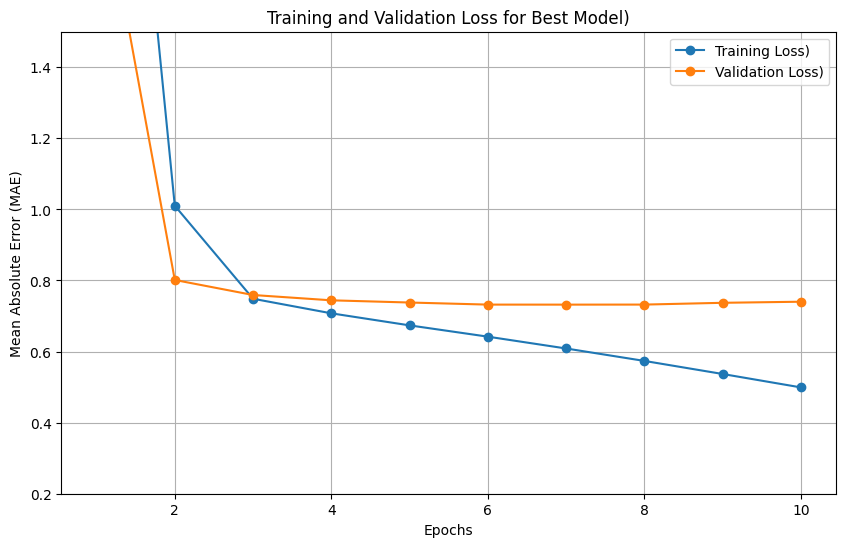

In [219]:
import matplotlib.pyplot as plt

# Extract training and validation loss
train_loss = best_history.history['loss']
val_loss = best_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
# Define batch size
batch_size = 256  # Replace with the actual batch size used during training

# Plotting the trace
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label=f'Training Loss)', marker='o')
plt.plot(epochs, val_loss, label=f'Validation Loss)', marker='o')
plt.title(f'Training and Validation Loss for Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.ylim(0.2, 1.5)
plt.legend()
plt.grid(True)
plt.show()


#### For Mid Model

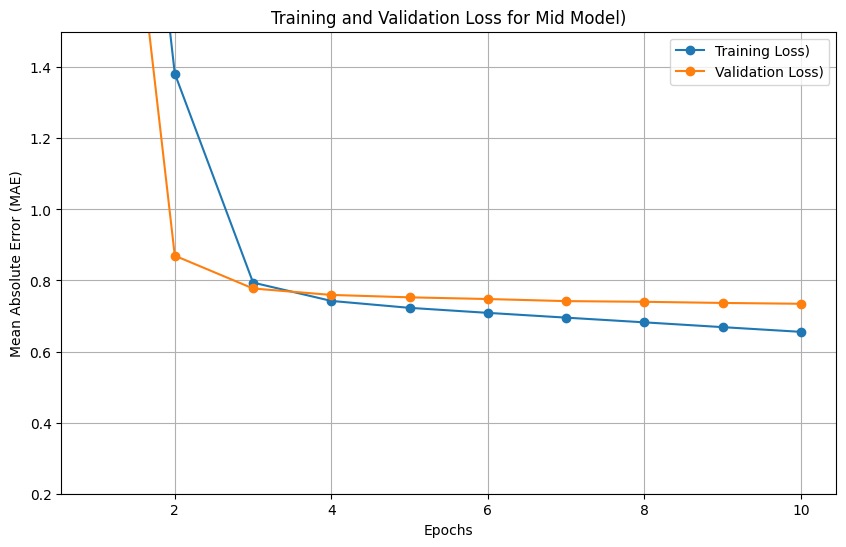

In [218]:
# Extract training and validation loss
train_loss = mid_history.history['loss']
val_loss = mid_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
# Define batch size
batch_size = 256  # Replace with the actual batch size used during training

# Plotting the trace
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label=f'Training Loss)', marker='o')
plt.plot(epochs, val_loss, label=f'Validation Loss)', marker='o')
plt.title(f'Training and Validation Loss for Mid Model)')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.ylim(0.2, 1.5)
plt.legend()
plt.grid(True)
plt.show()

#### For Worst Model

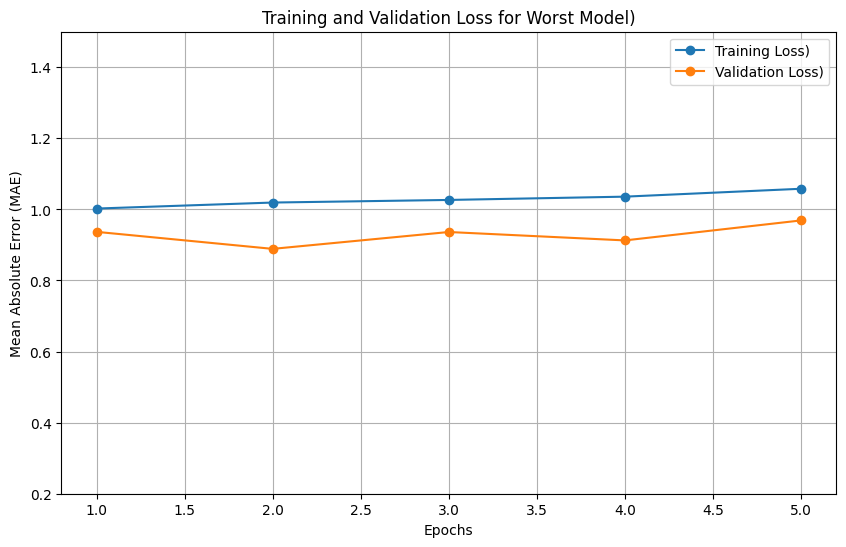

In [217]:
# Extract training and validation loss
train_loss = worst_history.history['loss']
val_loss = worst_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
# Define batch size
batch_size = 256  # Replace with the actual batch size used during training

# Plotting the trace
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label=f'Training Loss)', marker='o')
plt.plot(epochs, val_loss, label=f'Validation Loss)', marker='o')
plt.title(f'Training and Validation Loss for Worst Model)')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.ylim(0.2, 1.5)
plt.legend()
plt.grid(True)
plt.show()